In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns; sns.set(font_scale=1.5)  # plot formatting

> Linear Regression: Fit quickly, very interpretable

Linear Regression on multi-dimensional data
>  Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

### Example: simple linear regression

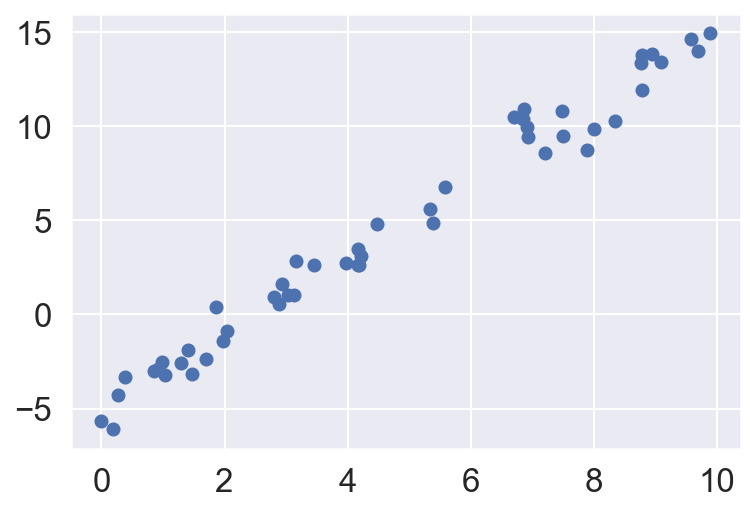

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


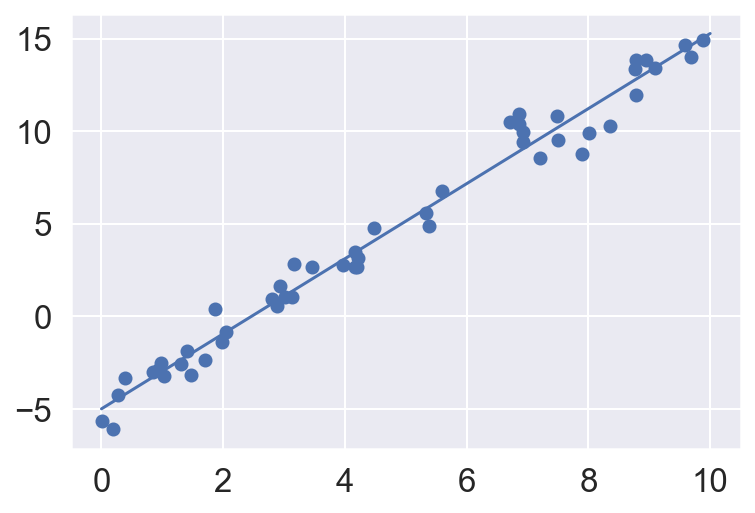

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Polynomial features

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

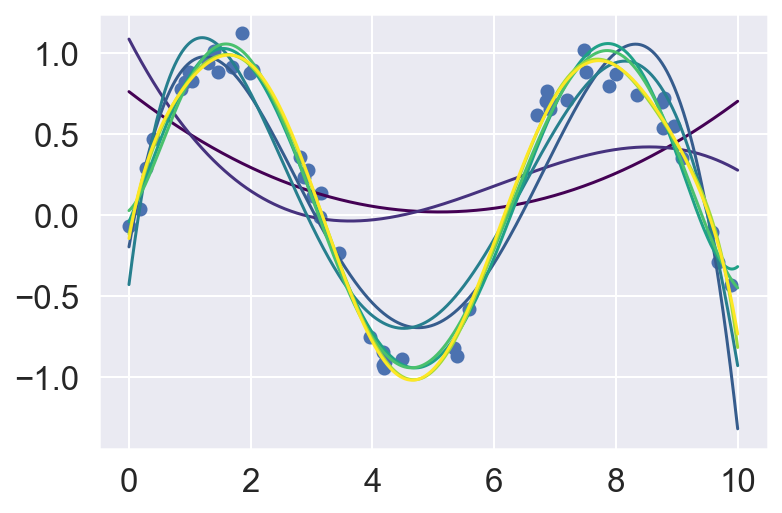

In [110]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)



def fit_predict(deg=2):
    poly_model = make_pipeline(PolynomialFeatures(deg),
                           LinearRegression())
    poly_model.fit(x[:, np.newaxis], y)
    
    yfit = poly_model.predict(xfit[:, np.newaxis])
    return yfit


plt.scatter(x, y)

degrees = np.arange(2,10)
cmap = cm.get_cmap('viridis', degrees.size)
colors = cmap(np.linspace(0,1,degrees.size))

yfits = np.array([fit_predict(deg) for deg in degrees])

lines = plt.plot(xfit, yfits.T);
for line, color in zip(lines, colors):
    line.set_color(color)


### Gaussian Basis Function

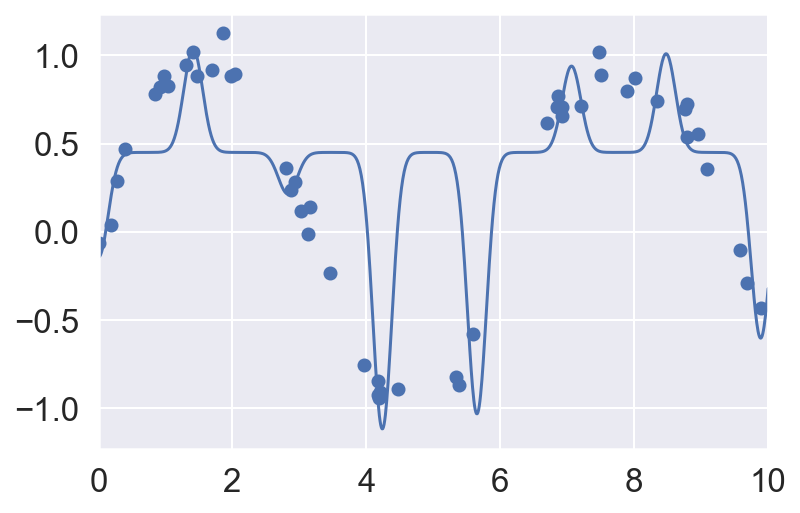

In [143]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(8,0.1),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

In [146]:
x_g = GaussianFeatures(8).fit(x[:, np.newaxis], y)

In [148]:
x_g.centers_

array([1.14374817e-03, 1.41363905e+00, 2.82613436e+00, 4.23862967e+00,
       5.65112497e+00, 7.06362028e+00, 8.47611558e+00, 9.88861089e+00])

(-2.887197273570043, 1.5)

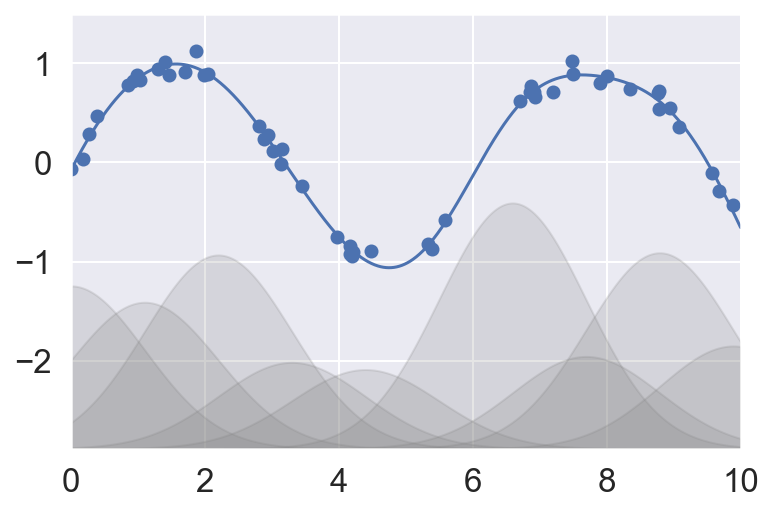

In [189]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly-spaced Gaussian Features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
xfit = np.linspace(0, 10, 1000)

NGs = 10
gauss_model = make_pipeline(GaussianFeatures(NGs, 1.0),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

gf = gauss_model.named_steps['gaussianfeatures']
lm = gauss_model.named_steps['linearregression']

fig, ax = plt.subplots()

for i in range(NGs):
    selector = np.zeros(NGs)
    selector[i] = 1
    Xfit = gf.transform(xfit[:, None]) * selector
    yfit = lm.predict(Xfit)
    ax.fill_between(xfit, yfit.min(), yfit, color='gray', alpha=0.2)

ax.scatter(x, y)
ax.plot(xfit, gauss_model.predict(xfit[:, np.newaxis]))
ax.set_xlim(0, 10)
ax.set_ylim(yfit.min(), 1.5)

### Test: inverse basis function $\frac{w}{(x-y)^2+1}$

(-5.1424409749154725, 1.5)

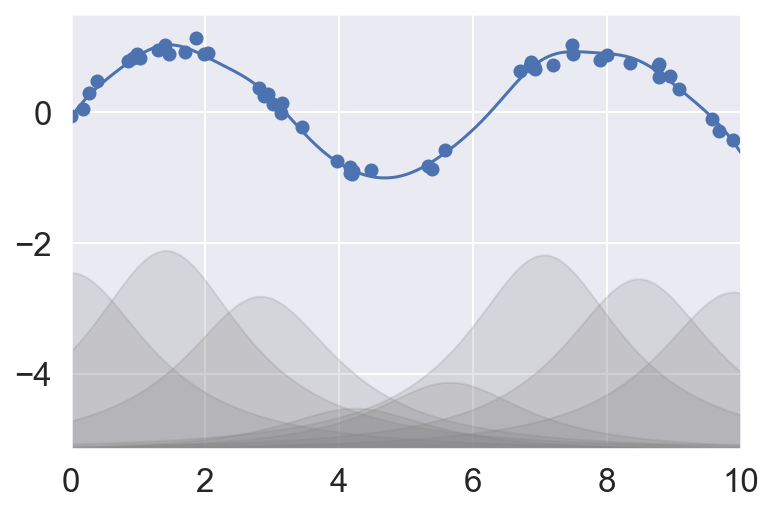

In [182]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin

class InverseFeatures(BaseEstimator, TransformerMixin):
    """Uniformly-spaced Inverse Features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _inverse_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return 1/(np.sum(arg ** 2, axis)+1)
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._inverse_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
xfit = np.linspace(0, 10, 1000)

NGs = 8
inverse_model = make_pipeline(InverseFeatures(NGs, 1.0),
                            LinearRegression())
inverse_model.fit(x[:, np.newaxis], y)
yfit = inverse_model.predict(xfit[:, np.newaxis])

gf = inverse_model.named_steps['inversefeatures']
lm = inverse_model.named_steps['linearregression']

fig, ax = plt.subplots()

for i in range(NGs):
    selector = np.zeros(NGs)
    selector[i] = 1
    Xfit = gf.transform(xfit[:, None]) * selector
    yfit = lm.predict(Xfit)
    ax.fill_between(xfit, yfit.min(), yfit, color='gray', alpha=0.2)

ax.scatter(x, y)
ax.plot(xfit, gauss_model.predict(xfit[:, np.newaxis]))
ax.set_xlim(0, 10)
ax.set_ylim(yfit.min(), 1.5)

### Extend: can we do a sine - basis function?

# Regression with regularization

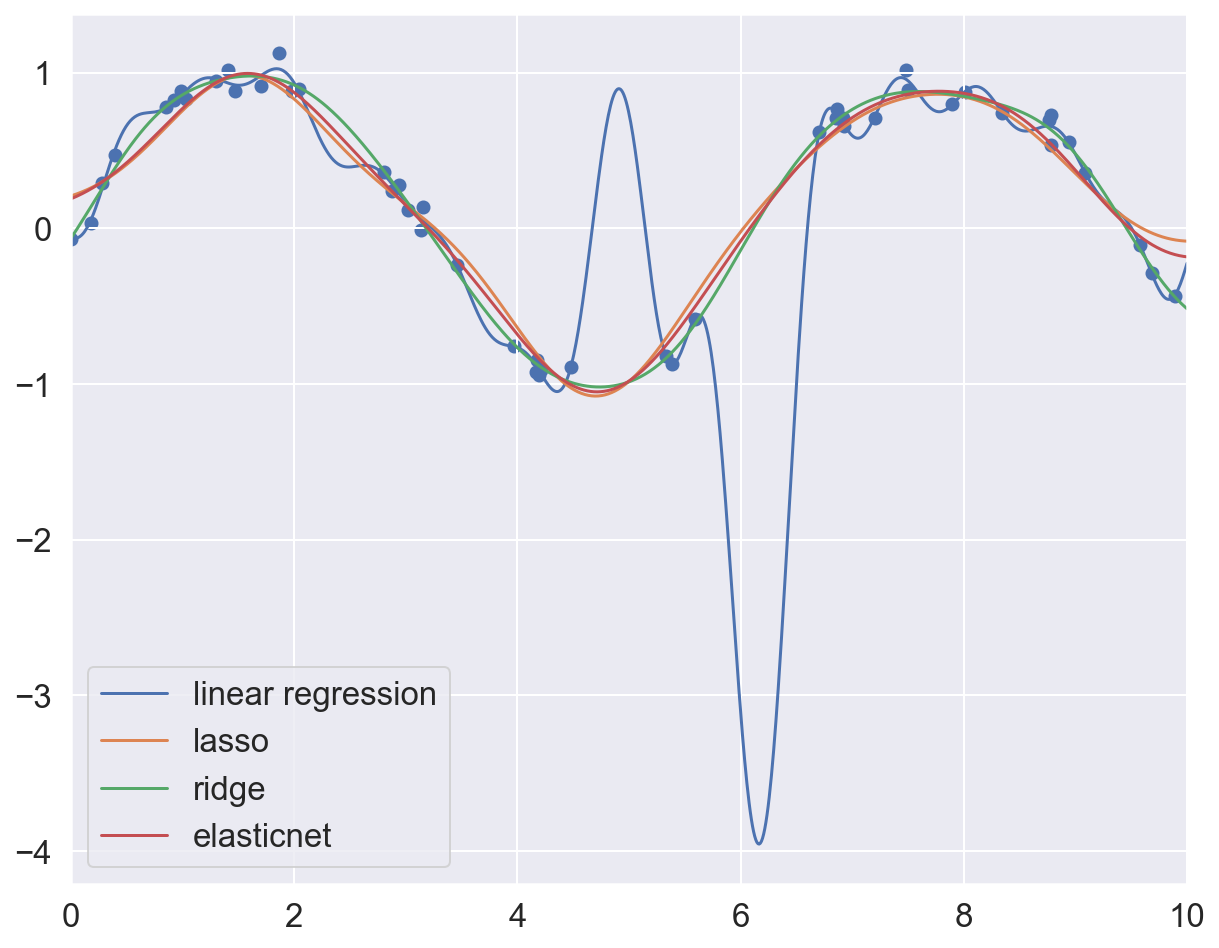

In [232]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

no_reg = make_pipeline(GaussianFeatures(30), LinearRegression())
lasso = make_pipeline(GaussianFeatures(30), Lasso(0.01))
ridge = make_pipeline(GaussianFeatures(30), Ridge(0.01))
elastic = make_pipeline(GaussianFeatures(30), ElasticNet(0.01))

models = [no_reg, lasso, ridge, elastic]

plt.figure(figsize=(10,8))
for model in models:
    
    model.fit(x[:, np.newaxis], y)
    yfit = model.predict(xfit[:, np.newaxis])
    plt.plot(xfit, yfit, label=model.get_params()['steps'][-1][0].replace('rr','r r'))

plt.legend(frameon=True)
plt.scatter(x, y, zorder=0)
plt.xlim(0, 10);

Lasso regularization has the benefit that it tends to set unnecessary coefficients to zero